In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import scanpy as sc
import episcanpy as epi
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import glob
import os
import helps

from pathlib import Path
import scipy

# Raw CM

## Peak

In [ ]:
fr_file="Datasets/PBMC/RawFiles/atac_fragments.tsv.gz"
metadata=pd.read_csv("Datasets/PBMC/RawFiles/PBMC_metadata.csv", index_col=0)
features_space="Peak"
features_file="Datasets/PBMC/RawFiles/PBMC_PeakCalling/PBMC_peaks.narrowPeak"
adata=create_count_matrix(fragments_file=fr_file, valid_bcs=list(set(metadata.index)), features_space=features_space, features_file=features_file, metadata=metadata)
adata.X=scipy.sparse.csr_matrix(adata.X.copy())
adata.layers["raw"]=scipy.sparse.csr_matrix(adata.X.copy())

In [ ]:
epi.pp.nucleosome_signal(adata,fr_file, n=10000)
epi.pp.tss_enrichment(adata, gtf="../AnnotRef/hs/T2T/GCF_009914755.1_T2T-CHM13v2.0_genomic.gtf.gz", source="BestRefSeq",
                      fragments=fr_file, n=5000, score="avg_score_of_center_region", distance_to_tss=1000, bp_per_flank=100)
Path("Datasets/PBMC/CM").mkdir(parents=True, exist_ok=True)
adata.write("Datasets/PBMC/CM/PBMC_Peak_Raw.h5ad", compression="gzip")

## GEX

In [ ]:
adata=sc.read_10x_mtx("Datasets/PBMC/RawFiles/filtered_feature_bc_matrix")
adata.X=scipy.sparse.csr_matrix(adata.X.copy())
adata.layers["raw"]=scipy.sparse.csr_matrix(adata.X.copy())
metadata=pd.read_csv("Datasets/PBMC/RawFiles/PBMC_metadata.csv", index_col=0)

In [ ]:
adata=adata[helps.intersection([adata.obs.index, metadata.index])]
adata.obs=metadata.loc[adata.obs.index]
sc.pp.scrublet(adata)

In [ ]:
adata.write("Datasets/PBMC/CM/PBMC_GEX_Raw.h5ad", compression="gzip")

## mRNA

In [ ]:
names = ["chr", "source", "type", "start", "stop", "score", "strand", "frame", "attribute"]
gtf_file="../AnnotRef/hs/T2T/GCF_009914755.1_T2T-CHM13v2.0_genomic.gtf.gz"
gtf=pd.read_csv(gtf_file, sep="\t", header=None, comment="#", names=names, dtype={"chr": str})
gtf=gtf[(gtf["type"]=="gene") & (gtf["source"]=="BestRefSeq")]

gene_names=[attr.replace("gene_id", "").strip().strip("\"") for feature_attr in gtf.attribute for attr in feature_attr.split(";") if attr.strip().startswith("gene_id")]
tmp = [attr.replace("gene_type", "").strip().strip("\"") for feature_attr in gtf.attribute for attr in feature_attr.split(";") if attr.strip().startswith("gene_type ")]
if not tmp:
    tmp = [attr.replace("gene_biotype", "").strip().strip("\"") for feature_attr in gtf.attribute for attr in feature_attr.split(";") if attr.strip().startswith("gene_biotype ")]

info=pd.DataFrame(data=[gene_names,tmp], index=["GeneName","GeneType"]).T

mRNA=adata[:, helps.intersection([adata.var.index, info[info["GeneType"]=="protein_coding"]["GeneName"]])]
adata.X=scipy.sparse.csr_matrix(adata.X.copy())
adata.layers["raw"]=scipy.sparse.csr_matrix(adata.X.copy())
mRNA.write("Datasets/PBMC/CM/PBMC_mRNA_Raw.h5ad", compression="gzip")

## lncRNA

In [ ]:
names = ["chr", "source", "type", "start", "stop", "score", "strand", "frame", "attribute"]
gtf_file="../AnnotRef/hs/T2T/GCF_009914755.1_T2T-CHM13v2.0_genomic.gtf.gz"
gtf=pd.read_csv(gtf_file, sep="\t", header=None, comment="#", names=names, dtype={"chr": str})
gtf=gtf[(gtf["type"]=="gene") & (gtf["source"]=="BestRefSeq")]

gene_names=[attr.replace("gene_id", "").strip().strip("\"") for feature_attr in gtf.attribute for attr in feature_attr.split(";") if attr.strip().startswith("gene_id")]
tmp = [attr.replace("gene_type", "").strip().strip("\"") for feature_attr in gtf.attribute for attr in feature_attr.split(";") if attr.strip().startswith("gene_type ")]
if not tmp:
    tmp = [attr.replace("gene_biotype", "").strip().strip("\"") for feature_attr in gtf.attribute for attr in feature_attr.split(";") if attr.strip().startswith("gene_biotype ")]

info=pd.DataFrame(data=[gene_names,tmp], index=["GeneName","GeneType"]).T

lncRNA=adata[:, helps.intersection([adata.var.index, info[info["GeneType"]=="lncRNA"]["GeneName"]])]
adata.X=scipy.sparse.csr_matrix(adata.X.copy())
adata.layers["raw"]=scipy.sparse.csr_matrix(adata.X.copy())
lncRNA.write("Datasets/PBMC/CM/PBMC_lncRNA_Raw.h5ad", compression="gzip")

# Processing

## Peak

In [3]:
adata=sc.read_h5ad("Datasets/PBMC/CM/PBMC_Peak_Raw.h5ad")

In [4]:
epi.pp.qc_stats(adata, verbose=False)

In [5]:
min_features = 10**np.quantile(adata.obs["log_n_features"], 0.05)
max_features = 10**np.quantile(adata.obs["log_n_features"], 0.95)
min_cells = 10**np.quantile(adata.var["log_n_cells"], 0.05)
max_cells = 10**np.quantile(adata.var["log_n_cells"], 0.95)

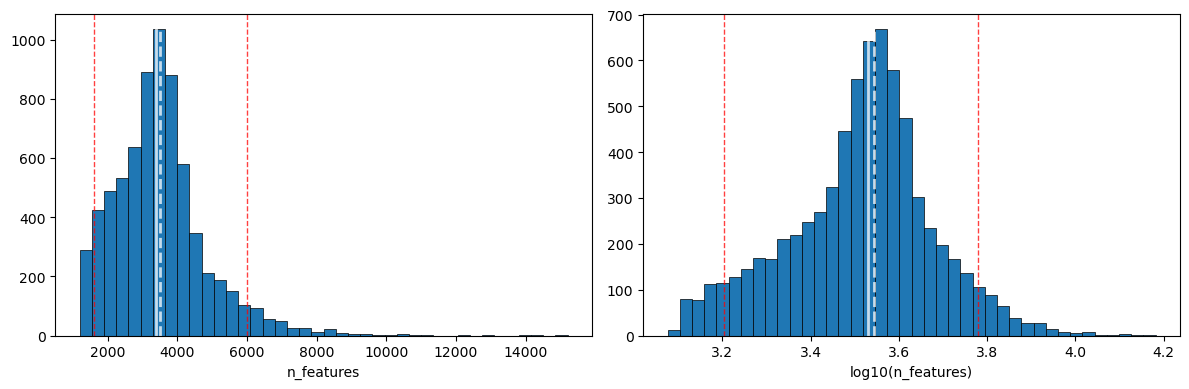

Max:	15199
Median:	3391.0
Mean:	3497.19966111268
Min:	1192


In [6]:
epi.pl.histogram(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True)

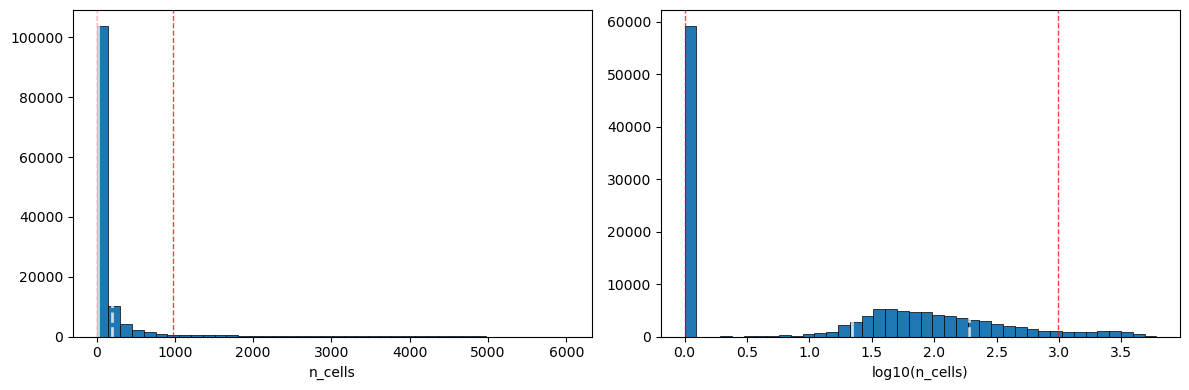

Max:	6025
Median:	22.0
Mean:	191.06783413693347
Min:	0


In [7]:
epi.pl.histogram(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True)

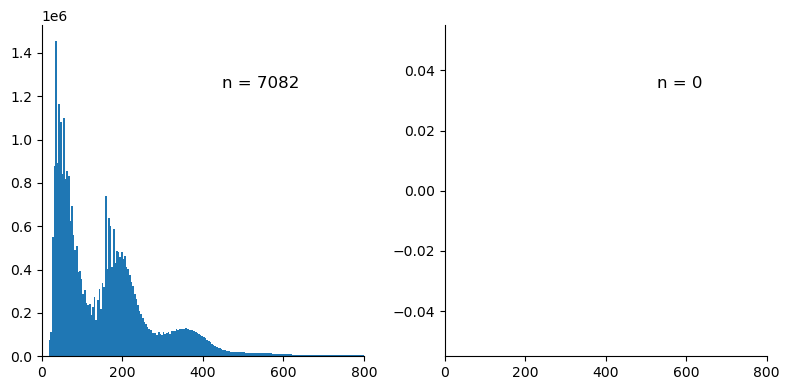

In [12]:
max_nucleosome_signal=2
epi.pl.fragment_length(adata, n=5000, threshold=max_nucleosome_signal, show_n=True)

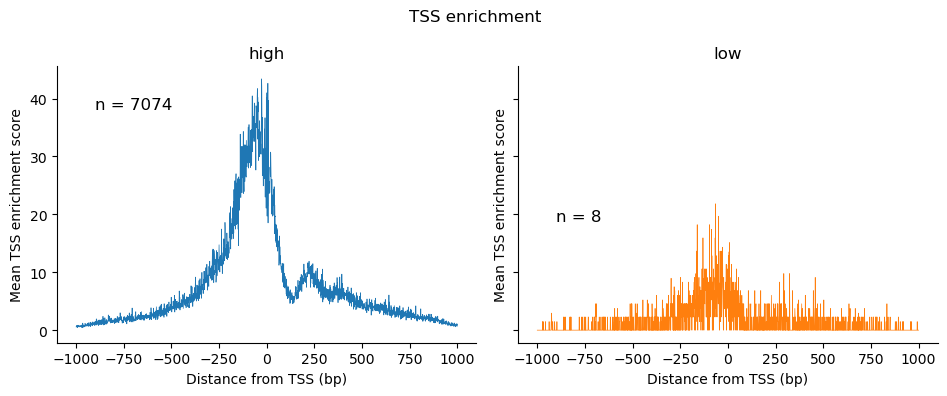

In [13]:
min_tss_enrichment = 3
adata.obs["tss"] = ["high" if val > min_tss_enrichment else "low" for val in adata.obs.tss_enrichment_score]

epi.pl.tss_enrichment(adata, group_by="tss", show_n=True)

In [14]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features, verbose=False)
epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, verbose=False)
adata = epi.pp.apply_filters(adata, verbose=False)
adata=adata[adata.obs.nucleosome_signal < max_nucleosome_signal]
adata=adata[adata.obs.tss_enrichment_score > min_tss_enrichment]
adata

View of AnnData object with n_obs × n_vars = 6371 × 63906
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'nucleosome_signal', 'tss_enrichment_score', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'tss', 'passes_filter'
    var: 'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter'
    uns: 'fragment_lengths', 'tss_enrichment'

In [15]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3')
min_var = np.quantile(adata.var.variances_norm, 0.7)
adata=adata[:, adata.var.variances_norm>min_var]
epi.pp.normalize_total(adata)
adata = adata[:, adata.X.max(axis=0)>0]
adata = adata[adata.X.max(axis=1)>0]
adata

View of AnnData object with n_obs × n_vars = 6371 × 19125
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'nucleosome_signal', 'tss_enrichment_score', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'tss', 'passes_filter'
    var: 'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fragment_lengths', 'tss_enrichment', 'hvg'

In [16]:
adata.write("Datasets/PBMC/CM/PBMC_Peak_Def.h5ad", compression="gzip")

## GEX

In [30]:
adata=sc.read_h5ad("Datasets/PBMC/CM/PBMC_GEX_Raw.h5ad")
adata

AnnData object with n_obs × n_vars = 7082 × 43925
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types'
    uns: 'scrublet'

In [31]:
epi.pp.qc_stats(adata, verbose=True)
mt_gene_mask = np.flatnonzero([gene.startswith(("MT","mt")) for gene in adata.var.index])
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


In [32]:
min_features = 10**np.quantile(adata.obs["log_n_features"], 0.05)
max_features = 10**np.quantile(adata.obs["log_n_features"], 0.95)
min_cells = 10**np.quantile(adata.var["log_n_cells"], 0.05)
max_cells = 10**np.quantile(adata.var["log_n_cells"], 0.95)

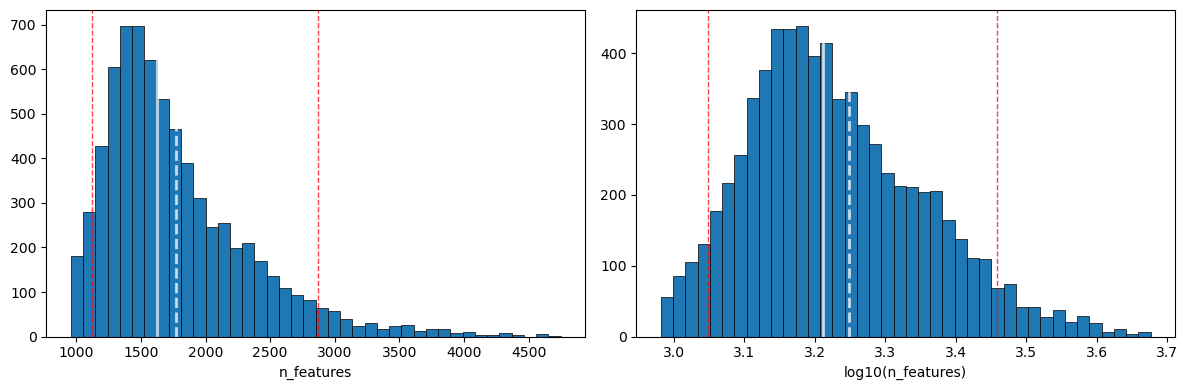

Max:	4747
Median:	1627.0
Mean:	1772.4618751765038
Min:	958


In [33]:
epi.pl.histogram(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True)

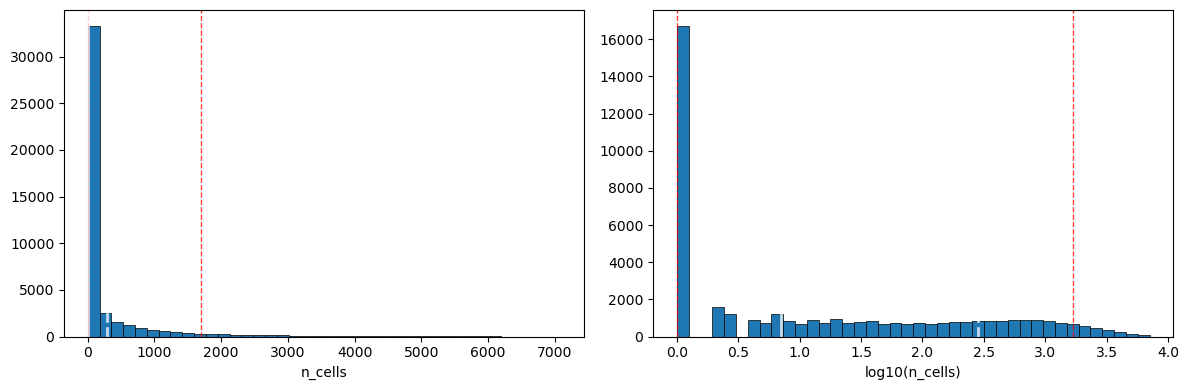

Max:	7082
Median:	7.0
Mean:	285.77290836653384
Min:	0


In [34]:
epi.pl.histogram(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True)

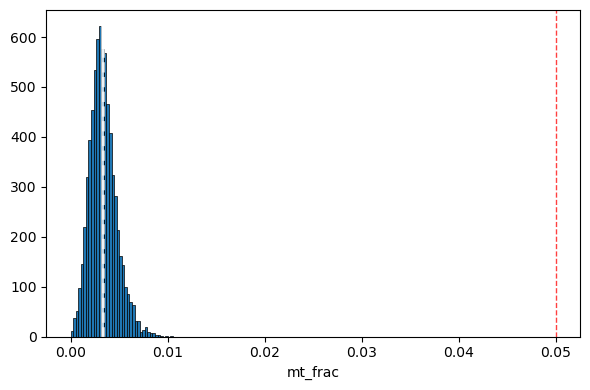

Max:	0.010538307949900627
Median:	0.003185075707733631
Mean:	0.0033200301695615053
Min:	0.0


In [35]:
epi.pl.histogram(adata, "mt_frac", max_threshold=0.05, show_log=False)

In [36]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features, verbose=False)
epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, verbose=False)
adata = epi.pp.apply_filters(adata, verbose=False)
adata = adata[adata.obs["mt_frac"]<=0.05]
adata=adata[adata.obs.predicted_doublet==False]
adata

View of AnnData object with n_obs × n_vars = 6371 × 27607
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'mt_frac', 'passes_filter'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter'
    uns: 'scrublet'

In [37]:
epi.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [38]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3')

In [40]:
min_var = np.quantile(adata.var.variances_norm, 0.85)
adata=adata[:, adata.var.variances_norm>min_var]
adata = adata[:, adata.X.max(axis=0)>0]
adata = adata[adata.X.max(axis=1)>0]
adata

View of AnnData object with n_obs × n_vars = 6371 × 4141
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'mt_frac', 'passes_filter'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'

In [41]:
adata.write("Datasets/PBMC/CM/PBMC_GEX_Def.h5ad", compression="gzip")

## mRNA

In [42]:
adata=sc.read_h5ad("Datasets/PBMC/CM/PBMC_mRNA_Raw.h5ad")
adata

AnnData object with n_obs × n_vars = 7082 × 9056
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types'
    uns: 'scrublet'

In [43]:
epi.pp.qc_stats(adata, verbose=True)
mt_gene_mask = np.flatnonzero([gene.startswith(("MT","mt")) for gene in adata.var.index])
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


In [44]:
min_features = 10**np.quantile(adata.obs["log_n_features"], 0.05)
max_features = 10**np.quantile(adata.obs["log_n_features"], 0.95)
min_cells = 10**np.quantile(adata.var["log_n_cells"], 0.05)
max_cells = 10**np.quantile(adata.var["log_n_cells"], 0.95)

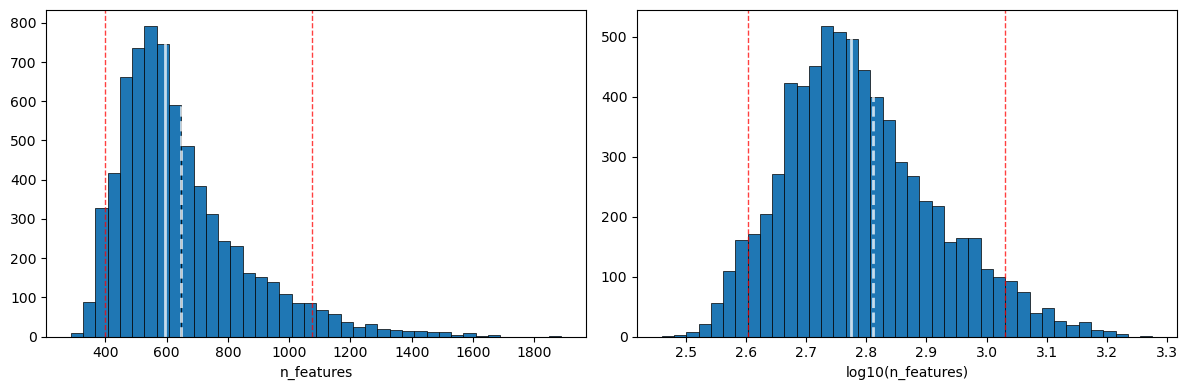

Max:	1888
Median:	594.0
Mean:	646.69966111268
Min:	288


In [45]:
epi.pl.histogram(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True)

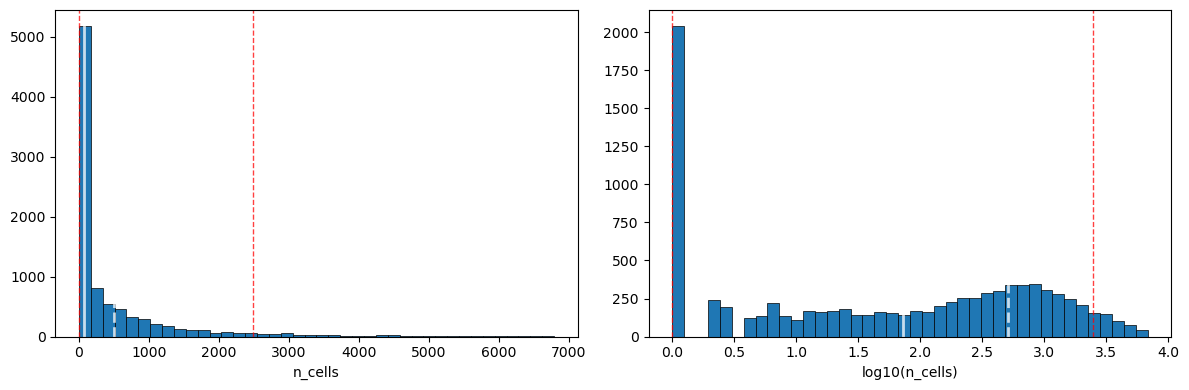

Max:	6785
Median:	72.0
Mean:	505.73398851590105
Min:	0


In [46]:
epi.pl.histogram(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True)

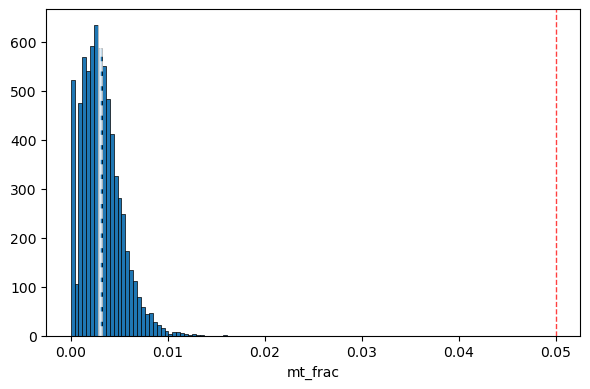

Max:	0.016129031777381897
Median:	0.0028901733458042145
Mean:	0.0031384339090436697
Min:	0.0


In [48]:
epi.pl.histogram(adata, "mt_frac", max_threshold=0.05, show_log=False)

In [49]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features, verbose=False)
epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, verbose=False)
adata = epi.pp.apply_filters(adata, verbose=False)
adata = adata[adata.obs["mt_frac"]<=0.05]
adata=adata[adata.obs.predicted_doublet==False]
adata

View of AnnData object with n_obs × n_vars = 6370 × 6979
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'mt_frac', 'passes_filter'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter'
    uns: 'scrublet'

In [50]:
epi.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [51]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3')

In [52]:
min_var = np.quantile(adata.var.variances_norm, 0.6)
adata=adata[:, adata.var.variances_norm>min_var]
adata = adata[:, adata.X.max(axis=0)>0]
adata = adata[adata.X.max(axis=1)>0]
adata

View of AnnData object with n_obs × n_vars = 6370 × 2792
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'mt_frac', 'passes_filter'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'

In [53]:
adata.write("Datasets/PBMC/CM/PBMC_mRNA_Def.h5ad", compression="gzip")

## lncRNA

In [54]:
adata=sc.read_h5ad("Datasets/PBMC/CM/PBMC_lncRNA_Raw.h5ad")
adata

AnnData object with n_obs × n_vars = 7082 × 5573
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types'
    uns: 'scrublet'

In [55]:
epi.pp.qc_stats(adata, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


In [56]:
min_features = 10**np.quantile(adata.obs["log_n_features"], 0.05)
max_features = 10**np.quantile(adata.obs["log_n_features"], 0.95)
min_cells = 10**np.quantile(adata.var["log_n_cells"], 0.05)
max_cells = 10**np.quantile(adata.var["log_n_cells"], 0.95)

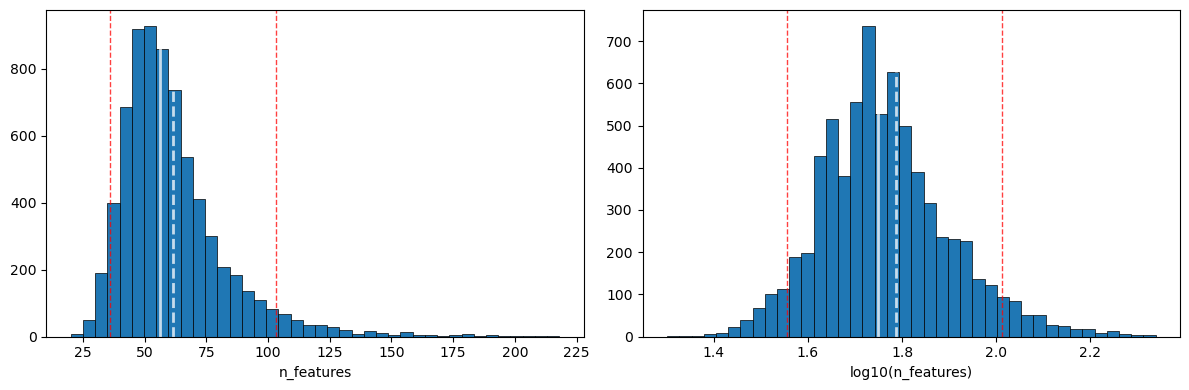

Max:	218
Median:	56.0
Mean:	61.2560011296244
Min:	20


In [57]:
epi.pl.histogram(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True)

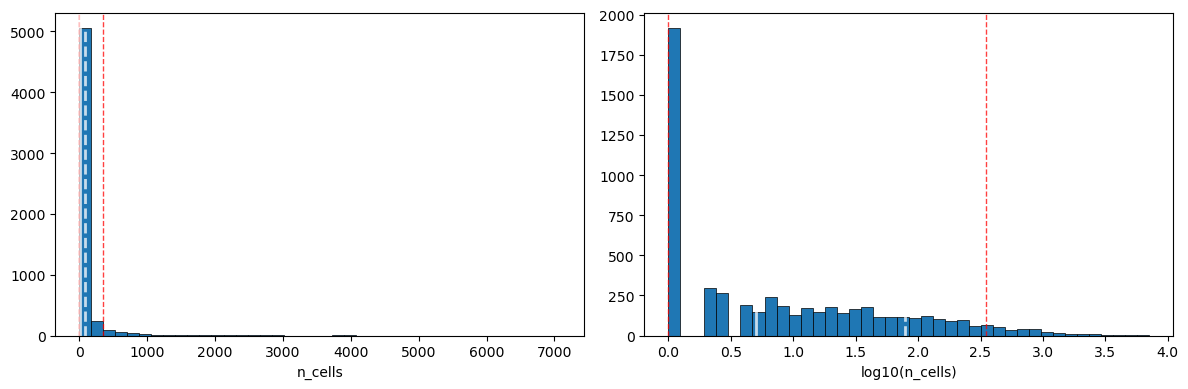

Max:	7082
Median:	5.0
Mean:	77.84227525569712
Min:	0


In [58]:
epi.pl.histogram(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True)

In [59]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features, verbose=False)
epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, verbose=False)
adata = epi.pp.apply_filters(adata, verbose=False)
adata=adata[adata.obs.predicted_doublet==False]
adata

View of AnnData object with n_obs × n_vars = 6408 × 3902
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'passes_filter'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter'
    uns: 'scrublet'

In [60]:
epi.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [61]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3')

In [62]:
min_var = np.quantile(adata.var.variances_norm, 0.4)
adata=adata[:, adata.var.variances_norm>min_var]
adata = adata[:, adata.X.max(axis=0)>0]
adata = adata[adata.X.max(axis=1)>0]
adata

View of AnnData object with n_obs × n_vars = 6408 × 2330
    obs: 'RNA_celltype', 'Raw_CellType', 'CellType', 'doublet_score', 'predicted_doublet', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'passes_filter'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'

In [63]:
adata.write("Datasets/PBMC/CM/PBMC_lncRNA_Def.h5ad", compression="gzip")

## Muon bjects

In [2]:
import muon as mu
peak=sc.read_h5ad(f"Datasets/PBMC/CM/PBMC_Peak_Def.h5ad")
gex=sc.read_h5ad(f"Datasets/PBMC/CM/PBMC_GEX_Def.h5ad")
mrna=sc.read_h5ad(f"Datasets/PBMC/CM/PBMC_mRNA_Def.h5ad")
lncrna=sc.read_h5ad(f"Datasets/PBMC/CM/PBMC_lncRNA_Def.h5ad")

#Peak + GEX
print("Peak + GEX")
inter=helps.intersection([peak.obs.index, gex.obs.index])
mudata=mu.MuData({"Peak" : peak[inter], "GEX" : gex[inter]})
mudata.write_h5mu(f"Datasets/PBMC/CM/PBMC_Peak_GEX_Def.h5mu", compression="gzip")

#Peak + mRNA
print("Peak + mRNA")
inter=helps.intersection([peak.obs.index, mrna.obs.index])
mudata=mu.MuData({"Peak" : peak[inter], "mRNA" : mrna[inter]})
mudata.write_h5mu(f"Datasets/PBMC/CM/PBMC_Peak_mRNA_Def.h5mu", compression="gzip")

#Peak + lncRNA
print("Peak + lncRNA")
inter=helps.intersection([peak.obs.index, lncrna.obs.index])
mudata=mu.MuData({"Peak" : peak[inter], "lncRNA" : lncrna[inter]})
mudata.write_h5mu(f"Datasets/PBMC/CM/PBMC_Peak_lncRNA_Def.h5mu", compression="gzip")

#mRNA + lncRNA
print("mRNA + lncRNA")
inter=helps.intersection([mrna.obs.index, lncrna.obs.index])
mudata=mu.MuData({"mRNA" : mrna[inter], "lncRNA" : lncrna[inter]})
mudata.write_h5mu(f"Datasets/PBMC/CM/PBMC_mRNA_lncRNA_Def.h5mu", compression="gzip")

#Peak + mRNA + lncRNA
print("Peak + mRNA + lncRNA")
inter=helps.intersection([peak.obs.index, mrna.obs.index, lncrna.obs.index])
mudata=mu.MuData({"Peak" : peak[inter], "mRNA" : mrna[inter], "lncRNA" : lncrna[inter]})
mudata.write_h5mu(f"Datasets/PBMC/CM/PBMC_Peak_mRNA_lncRNA_Def.h5mu", compression="gzip")

Peak + GEX
Peak + mRNA
Peak + lncRNA
mRNA + lncRNA
Peak + mRNA + lncRNA


In [16]:
for fs in ["Peak","GEX","mRNA","lncRNA"]:
    print(fs)
    adata_raw=sc.read_h5ad(f"Datasets/PBMC/CM/PBMC_{fs}_Raw.h5ad")
    adata_raw.X=scipy.sparse.csr_matrix(adata_raw.X.copy())
    adata_raw.layers["raw"]=scipy.sparse.csr_matrix(adata_raw.X.copy())
    adata_raw.write(f"Datasets/PBMC/CM/PBMC_{fs}_Raw.h5ad", compression="gzip")

    adata=sc.read_h5ad(f"Datasets/PBMC/CM/PBMC_{fs}_Def.h5ad")
    adata_raw=adata_raw[adata.obs.index, adata.var.index]
    adata.layers["raw"]=scipy.sparse.csr_matrix(adata_raw.X.copy())
    adata.write(f"Datasets/PBMC/CM/PBMC_{fs}_Def.h5ad", compression="gzip")

Peak
GEX
mRNA
lncRNA
